## Repositório para import do iob_transform:

In [25]:
#!git clone -s https://github.com/mstauffer/tcdf_text_classification.git

## Import de módulos

In [76]:
import pandas as pd
import nltk
import scipy.stats
import sklearn
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
import matplotlib.pyplot as plt
%matplotlib inline
nltk.download('punkt')
from seqeval.metrics import f1_score, classification_report

[nltk_data] Downloading package punkt to
[nltk_data]     /home/lucelia_vieira/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.9.1
GPU detected: []


In [39]:
data = pd.read_csv('/home/lucelia_vieira/Experimentos/ner/CSVs/DODFCorpus_contratos_licitacoes_v0.csv', dtype=str)

In [40]:
#lista os labels do dataset
labels = data["tipo_ent"].unique()
labels.sort()
labels

array(['AVISO_ANUL_REV_LICITACAO', 'AVISO_LICITACAO',
       'AVISO_SUSPENSAO_LICITACAO', 'EXTRATO_ADITAMENTO_CONTRATUAL',
       'EXTRATO_CONTRATO', 'EXTRATO_CONVENIO', 'cnpj_entidade_contratada',
       'cnpj_entidade_convenente', 'cnpj_orgao_concedente',
       'cnpj_orgao_contratante', 'codigo_licitacao_sistema_compras',
       'data_abertura_licitacao', 'data_assinatura_contrato',
       'data_assinatura_convenio', 'data_escrito', 'decisao_tcdf',
       'entidade_contratada', 'entidade_convenente', 'fonte_recurso',
       'identificacao_ocorrencia', 'modalidade_licitacao',
       'natureza_despesa', 'nome_responsavel', 'nota_empenho',
       'numero_contrato', 'numero_convenio', 'numero_licitacao',
       'numero_termo_aditivo', 'objeto_aditamento_contratual',
       'objeto_contrato', 'objeto_convenio', 'objeto_licitacao',
       'orgao_concedente', 'orgao_contratante', 'orgao_licitante',
       'processo_gdf', 'programa_trabalho', 'sistema_compras',
       'tipo_objeto', 'unidad

In [30]:
#lista os tipos de atos 
tipo = data["tipo_rel"].unique()
tipo

array(['REL_EXTRATO_CONTRATO', 'REL_ADITAMENTO_CONTRATO',
       'REL_AVISO_LICITACAO', 'REL_ANUL_REVOG_LICITACAO',
       'REL_SUSPENSAO_LICITACAO', 'REL_EXTRATO_CONVENIO'], dtype=object)

In [41]:
tipo_ato = data[data["tipo_rel"]=="REL_EXTRATO_CONTRATO"]

In [32]:
tipo_ato

,id_dodf,tipo_rel,id_rel,anotador_rel,tipo_ent,id_ent,anotador_ent,offset,length,texto
0,3_4.7.2019,REL_EXTRATO_CONTRATO,R2,anotador_44068453,orgao_contratante,105,anotador_44068453,310795,49,SECRETARIA DE ESTADO DE SAUDE DO DISTRITO FEDERAL
1,3_4.7.2019,REL_EXTRATO_CONTRATO,R2,anotador_44068453,processo_gdf,114,anotador_44068453,312099,22,00060-00144591/2019-21
2,3_4.7.2019,REL_EXTRATO_CONTRATO,R2,anotador_44068453,entidade_contratada,123,anotador_44068453,310857,34,SAMEH -\nSOLUCOES HOSPITALARES LTDA
3,3_4.7.2019,REL_EXTRATO_CONTRATO,R2,anotador_44068453,cnpj_entidade_contratada,124,anotador_44068453,310913,18,25.031.668/0001-27
4,3_4.7.2019,REL_EXTRATO_CONTRATO,R2,anotador_44068453,data_assinatura_contrato,125,anotador_44068453,312143,10,25/06/2019
...,...,...,...,...,...,...,...,...,...,...
158587,634,REL_EXTRATO_CONTRATO,R176,anotador_84982792,unidade_orcamentaria,651,anotador_84982792,285502,6,09.108
158588,634,REL_EXTRATO_CONTRATO,R176,anotador_84982792,programa_trabalho,652,anotador_84982792,285514,21,15.451.6209.1968.0058
158589,634,REL_EXTRATO_CONTRATO,R176,anotador_84982792,nota_empenho,655,anotador_84982792,285582,11,2021NE00476
158590,634,REL_EXTRATO_CONTRATO,R176,anotador_84982792,vigencia_contrato,649,anotador_84982792,285677,243,O prazo de vigência contratual será de 12 (doz...


In [42]:
tipo_ato['id_ato'] = tipo_ato['id_dodf'] + '-' + tipo_ato['id_rel']

/tmp/ipykernel_129927/3434964974.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tipo_ato['id_ato'] = tipo_ato['id_dodf'] + '-' + tipo_ato['id_rel']


In [34]:
tipo_ato

,id_dodf,tipo_rel,id_rel,anotador_rel,tipo_ent,id_ent,anotador_ent,offset,length,texto,id_ato
0,3_4.7.2019,REL_EXTRATO_CONTRATO,R2,anotador_44068453,orgao_contratante,105,anotador_44068453,310795,49,SECRETARIA DE ESTADO DE SAUDE DO DISTRITO FEDERAL,3_4.7.2019-R2
1,3_4.7.2019,REL_EXTRATO_CONTRATO,R2,anotador_44068453,processo_gdf,114,anotador_44068453,312099,22,00060-00144591/2019-21,3_4.7.2019-R2
2,3_4.7.2019,REL_EXTRATO_CONTRATO,R2,anotador_44068453,entidade_contratada,123,anotador_44068453,310857,34,SAMEH -\nSOLUCOES HOSPITALARES LTDA,3_4.7.2019-R2
3,3_4.7.2019,REL_EXTRATO_CONTRATO,R2,anotador_44068453,cnpj_entidade_contratada,124,anotador_44068453,310913,18,25.031.668/0001-27,3_4.7.2019-R2
4,3_4.7.2019,REL_EXTRATO_CONTRATO,R2,anotador_44068453,data_assinatura_contrato,125,anotador_44068453,312143,10,25/06/2019,3_4.7.2019-R2
...,...,...,...,...,...,...,...,...,...,...,...
158587,634,REL_EXTRATO_CONTRATO,R176,anotador_84982792,unidade_orcamentaria,651,anotador_84982792,285502,6,09.108,634-R176
158588,634,REL_EXTRATO_CONTRATO,R176,anotador_84982792,programa_trabalho,652,anotador_84982792,285514,21,15.451.6209.1968.0058,634-R176
158589,634,REL_EXTRATO_CONTRATO,R176,anotador_84982792,nota_empenho,655,anotador_84982792,285582,11,2021NE00476,634-R176
158590,634,REL_EXTRATO_CONTRATO,R176,anotador_84982792,vigencia_contrato,649,anotador_84982792,285677,243,O prazo de vigência contratual será de 12 (doz...,634-R176


In [43]:
from iob_transformer import iob_transformer
iob = iob_transformer('id_ato', 'texto','tipo_ent', keep_punctuation=True, return_df=False)

In [57]:
atos, labels = iob.transform(tipo_ato)

## Listas para palavras e tags únicas

In [58]:
words = set()
for ato in atos:
    for termo in ato:
        words.add(termo)
words = list(words)
words.append("ENDPAD")
words.append("UNK")
num_words = len(words)
num_words

18621

In [59]:
words

['19',
 '2021NE12383',
 '00150-00003790/2021-95',
 '00050-00010768/2021-48-SSP',
 '2021NE00682',
 'cirurgias',
 'GAL',
 'Lore',
 '483EDF0010',
 'WANDERLEY',
 'organizacional',
 '2021NE12323',
 'Acréscimo',
 'M1',
 'Impressão',
 'ABREU',
 '33.90.30.16',
 'KALIL',
 '14.422.6211.2627.0002',
 'indireta',
 '3463/',
 '4.611/2011',
 'processada',
 '271',
 '041/2019',
 '04001-0000000461/2021-75',
 '54.266,00',
 'fins',
 'LOIOLA',
 'demais',
 'interligação',
 '138003467',
 '75886402',
 '00399/2021',
 'Refeicao',
 'Function',
 'ALMIR',
 'Vedação',
 '21.961,00',
 'inferior',
 'Hermético',
 '7.260.000,00',
 'VIGÊNCIA:17/09/2021',
 '11.862.021/0001-32',
 'ratifica',
 'parque',
 'GNSS',
 '66309455',
 'VIBRADORES',
 '365/2021',
 'HABITACIONAL',
 'Torres',
 'CATANANTI',
 '23901',
 'vinculados',
 'ao',
 '108/2021',
 'canto',
 'ANALISES',
 'amparo',
 'senta',
 'Tenda',
 '4.28',
 'RAVEL',
 'GRUPO',
 '72626851',
 '45589/2021',
 'Concurso',
 '24909',
 'URBANO',
 '139/2021',
 '22.206.013.021-0',
 'mIU/ml',


In [60]:
tags = set()

for label in labels:
    for tag in label:
        tags.add(tag)
tags = list(tags)
num_tags = len(tags)
num_tags

46

In [51]:
tags

['B-orgao_contratante',
 'I-data_abertura_licitacao',
 'I-natureza_despesa',
 'I-data_assinatura_contrato',
 'I-fonte_recurso',
 'I-objeto_contrato',
 'I-objeto_licitacao',
 'B-numero_licitacao',
 'B-modalidade_licitacao',
 'B-vigencia_contrato',
 'B-fonte_recurso',
 'I-entidade_contratada',
 'B-processo_gdf',
 'I-orgao_contratante',
 'B-cnpj_entidade_contratada',
 'B-codigo_licitacao_sistema_compras',
 'B-numero_contrato',
 'B-cnpj_orgao_contratante',
 'I-processo_gdf',
 'B-programa_trabalho',
 'B-unidade_orcamentaria',
 'I-cnpj_entidade_contratada',
 'B-data_abertura_licitacao',
 'I-nota_empenho',
 'B-natureza_despesa',
 'B-valor_contrato',
 'B-data_assinatura_contrato',
 'I-modalidade_licitacao',
 'I-cnpj_orgao_contratante',
 'I-valor_contrato',
 'I-nome_responsavel',
 'I-programa_trabalho',
 'B-sistema_compras',
 'B-objeto_contrato',
 'B-entidade_contratada',
 'B-orgao_licitante',
 'O',
 'B-valor_estimado_contratacao',
 'B-nome_responsavel',
 'B-objeto_licitacao',
 'I-sistema_compr

## Mapeamento de palavras e tags em valores inteiros
Dicts..

In [61]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [62]:
tag2idx

{'B-orgao_contratante': 0,
 'I-data_abertura_licitacao': 1,
 'I-natureza_despesa': 2,
 'I-data_assinatura_contrato': 3,
 'I-fonte_recurso': 4,
 'I-objeto_contrato': 5,
 'I-objeto_licitacao': 6,
 'B-numero_licitacao': 7,
 'B-modalidade_licitacao': 8,
 'B-vigencia_contrato': 9,
 'B-fonte_recurso': 10,
 'I-entidade_contratada': 11,
 'B-processo_gdf': 12,
 'I-orgao_contratante': 13,
 'B-cnpj_entidade_contratada': 14,
 'B-codigo_licitacao_sistema_compras': 15,
 'B-numero_contrato': 16,
 'B-cnpj_orgao_contratante': 17,
 'I-processo_gdf': 18,
 'B-programa_trabalho': 19,
 'B-unidade_orcamentaria': 20,
 'I-cnpj_entidade_contratada': 21,
 'B-data_abertura_licitacao': 22,
 'I-nota_empenho': 23,
 'B-natureza_despesa': 24,
 'B-valor_contrato': 25,
 'B-data_assinatura_contrato': 26,
 'I-modalidade_licitacao': 27,
 'I-cnpj_orgao_contratante': 28,
 'I-valor_contrato': 29,
 'I-nome_responsavel': 30,
 'I-programa_trabalho': 31,
 'B-sistema_compras': 32,
 'B-objeto_contrato': 33,
 'B-entidade_contratada'

## Padding das sentenças

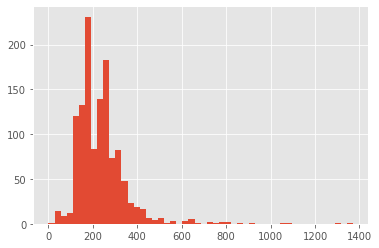

In [20]:
plt.hist([len(ato) for ato in atos], bins=50)
plt.show()

In [63]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 128

X = [[word2idx[w] for w in ato] for ato in atos]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=word2idx['ENDPAD'])

y = [[tag2idx[w] for w in label] for label in labels]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

Definindo o tamanho do Treino e do Teste

In [65]:
from sklearn.model_selection import train_test_split
# 80% treino, 20% teste
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# 10% teste, 10% validação
#x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=1)

## Rede Neural: Bi-LSTM
Usando apenas o Bi-LSTM

In [66]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [67]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words+1, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding (Embedding)       (None, 128, 50)           931100    
                                                                 
 spatial_dropout1d (SpatialD  (None, 128, 50)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 128, 200)         120800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 128, 46)          9246      
 ibuted)                                                         
                                                             

2022-08-04 15:43:17.175062: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Otimizador 
Melhoria do treinamento: https://keras.io/api/optimizers/.

In [68]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

## Treinamento do modelo

In [70]:
#!pip install livelossplot
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

Treinar por 15 épocas em CPU. Olhar o gráfico de acurácia e loss: se os gráficos não estabilizaram, talvez possa ser interessante aumentar o número de épocas. Usando o EarlyStopping a rede para de treinar se o modelo não melhorar em mais de n épocas consecutivas, onde n é o parâmetro de patience.

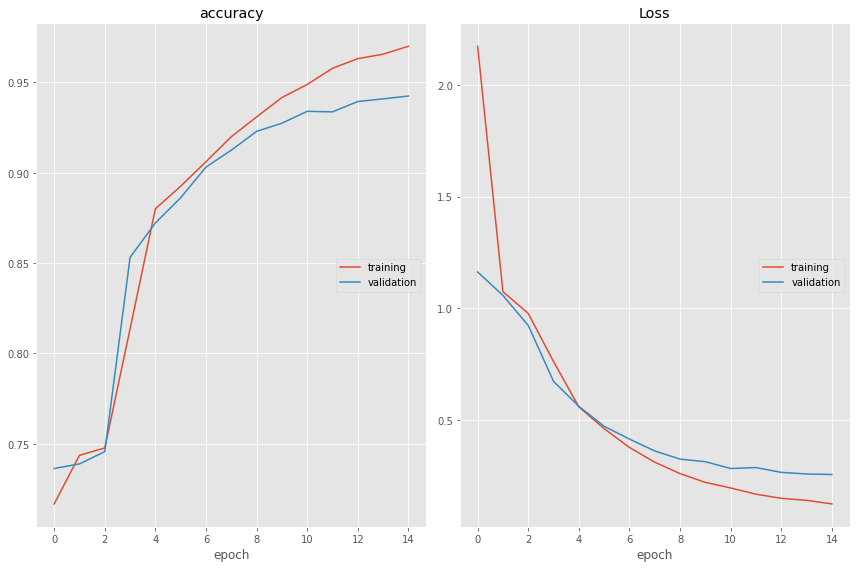

accuracy
	training         	 (min:    0.717, max:    0.970, cur:    0.970)
	validation       	 (min:    0.736, max:    0.942, cur:    0.942)
Loss
	training         	 (min:    0.125, max:    2.173, cur:    0.125)
	validation       	 (min:    0.256, max:    1.163, cur:    0.256)

Epoch 15: val_loss improved from 0.25868 to 0.25627, saving model to model.h5
31/31 [==============================] - 3s 83ms/step - loss: 0.1246 - accuracy: 0.9700 - val_loss: 0.2563 - val_accuracy: 0.9425
CPU times: user 3min 7s, sys: 9 s, total: 3min 16s
Wall time: 41.7 s


In [71]:
%%time

chkpt = ModelCheckpoint("model.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=False, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), chkpt, early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32, 
    epochs=15,
    callbacks=callbacks,
    verbose=1
)

## Avaliação do modelo 


In [72]:
model.evaluate(x_val, y_val)

4/4 [==============================] - 0s 11ms/step - loss: 0.2400 - accuracy: 0.9436


[0.24001732468605042, 0.9435975551605225]

In [73]:
y_pred_lstm = model.predict(x_val, batch_size=32, verbose=2)
# explicação shape: (instâncias, palavras em cada instância(max_len), prob de cada label)
y_pred_lstm.shape

4/4 - 0s - 307ms/epoch - 77ms/step


(123, 128, 46)

In [74]:
y_val.shape

(123, 128)

In [75]:
index_array = np.argmax(y_pred_lstm, axis=-1)
index_array.shape

(123, 128)

In [77]:
#extraindo as tags

idx2tag = {v: k for k, v in tag2idx.items()}
idx2tag

{0: 'B-orgao_contratante',
 1: 'I-data_abertura_licitacao',
 2: 'I-natureza_despesa',
 3: 'I-data_assinatura_contrato',
 4: 'I-fonte_recurso',
 5: 'I-objeto_contrato',
 6: 'I-objeto_licitacao',
 7: 'B-numero_licitacao',
 8: 'B-modalidade_licitacao',
 9: 'B-vigencia_contrato',
 10: 'B-fonte_recurso',
 11: 'I-entidade_contratada',
 12: 'B-processo_gdf',
 13: 'I-orgao_contratante',
 14: 'B-cnpj_entidade_contratada',
 15: 'B-codigo_licitacao_sistema_compras',
 16: 'B-numero_contrato',
 17: 'B-cnpj_orgao_contratante',
 18: 'I-processo_gdf',
 19: 'B-programa_trabalho',
 20: 'B-unidade_orcamentaria',
 21: 'I-cnpj_entidade_contratada',
 22: 'B-data_abertura_licitacao',
 23: 'I-nota_empenho',
 24: 'B-natureza_despesa',
 25: 'B-valor_contrato',
 26: 'B-data_assinatura_contrato',
 27: 'I-modalidade_licitacao',
 28: 'I-cnpj_orgao_contratante',
 29: 'I-valor_contrato',
 30: 'I-nome_responsavel',
 31: 'I-programa_trabalho',
 32: 'B-sistema_compras',
 33: 'B-objeto_contrato',
 34: 'B-entidade_contrat

In [79]:
# seqeval pede listas de listas de strings como entrada.
# esse pós-processamento mapeia os labels inteiros com suas
# respectivas strings. É importante montar listas para atos
# e fazer append dessas listas com a lista externa depois.
# SÓ FUNCIONA DESSE JEITO!
def numpy_to_seqeval(y_true, y_pred):
  '''
    Parameters:
    y_true: labels verdadeiros (num_atos, max_len)
    y_pred: saída do model.predict com argmax axis=-1 (num_atos, max_len)

    Returns:
    ground_truth: lista de listas com strings de cada tag para
    os labels verdadeiros
    tags_preditas: lista de listas com strings de cada tag para
    os labels preditos
  '''
  tags_preditas = []
  ground_truth = []
  for ato in y_pred:
    tags_ato = []
    for palavra in ato:
      tags_ato.append(idx2tag[palavra])
    tags_preditas.append(tags_ato)

  for ato in y_true:
    tags_ato = []
    for palavra in ato:
      tags_ato.append(idx2tag[palavra])
    ground_truth.append(tags_ato)
  
  return ground_truth, tags_preditas

In [80]:
gt, tags_pred = numpy_to_seqeval(y_val, index_array)

In [81]:
f1_score(gt, tags_pred)

0.6306420851875397

In [82]:
print(classification_report(gt, tags_pred))

                            precision    recall  f1-score   support

  cnpj_entidade_contratada       0.00      0.00      0.00         9
    cnpj_orgao_contratante       0.00      0.00      0.00         1
   data_abertura_licitacao       0.00      0.00      0.00         1
  data_assinatura_contrato       0.80      0.69      0.74        70
       entidade_contratada       0.19      0.25      0.22        32
             fonte_recurso       0.92      0.84      0.88        81
          natureza_despesa       0.86      0.67      0.75        64
          nome_responsavel       0.83      0.79      0.81        19
              nota_empenho       0.28      0.06      0.11        77
           numero_contrato       0.00      0.00      0.00        21
           objeto_contrato       0.35      0.54      0.43        59
          objeto_licitacao       0.00      0.00      0.00         1
         orgao_contratante       0.83      0.77      0.80        70
              processo_gdf       1.00      0.29

/home/lucelia_vieira/Experimentos/venv/lib/python3.8/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
